In [1]:
from desispec.io import read_spectra
from desitrip.preproc import rebin_flux, rescale_flux

from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow
from joblib import Parallel, delayed

from astropy.table import Table

import os
import sys
import shutil
import platform

import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import Callback, ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix

mpl.rc('font', size=14)
np.set_printoptions(suppress=True, threshold=sys.maxsize)

In [2]:
def condition_spectra(coadd_files, truth_files):
    """Read DESI spectra, rebin to a subsampled logarithmic wavelength grid, and rescale.
    
    Parameters
    ----------
    coadd_files : list or ndarray
        List of FITS files on disk with DESI spectra.
    truth_files : list or ndarray
        Truth files.
    
    Returns
    -------
    fluxes : ndarray
        Array of fluxes rebinned to a logarithmic wavelength grid.
    """
    fluxes = None
    
    for cf, tf in zip(coadd_files, truth_files):
        spectra = read_spectra(cf)
        wave = spectra.wave['brz']
        flux = spectra.flux['brz']
        ivar = spectra.ivar['brz']
        
        truth = Table.read(tf, 'TRUTH')
        try:
            truez = truth['TRUEZ']
        except:
            print(truth)
            print(cf, tf)

#         # Pre-condition: remove spectra with NaNs and zero flux values.
#         mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
#         mask_idx = np.argwhere(mask)
#         flux = np.delete(flux, mask_idx, axis=0)
#         ivar = np.delete(ivar, mask_idx, axis=0)

        # Rebin and rescale fluxes so that each is normalized between 0 and 1.
        rewave, reflux, reivar = rebin_flux(wave, flux, ivar, truez, minwave=2500., maxwave=9500., nbins=150, log=True, clip=True)
        rsflux = rescale_flux(reflux)

        if fluxes is None:
            fluxes = rsflux
        else:
            fluxes = np.concatenate((fluxes, rsflux))
    
    return fluxes

## Load model and save path

Load a "best model" from one training session (automatically saved by early stopping and model checkpointing).
Save the path that leads to the models for future use.

In [3]:
model = load_model('/global/homes/l/lehsani/timedomain/desitrip/docs/nb/models_new_3label/3_b65_e200_3label/b65_e200_best_model.h5')
path = '/global/homes/l/lehsani/redbluegen/gw170817_models'

## Plot spectra

Plots the original GW170817 spectra from each timestep.

(2039, 2)
[3961.45504244    0.        ]


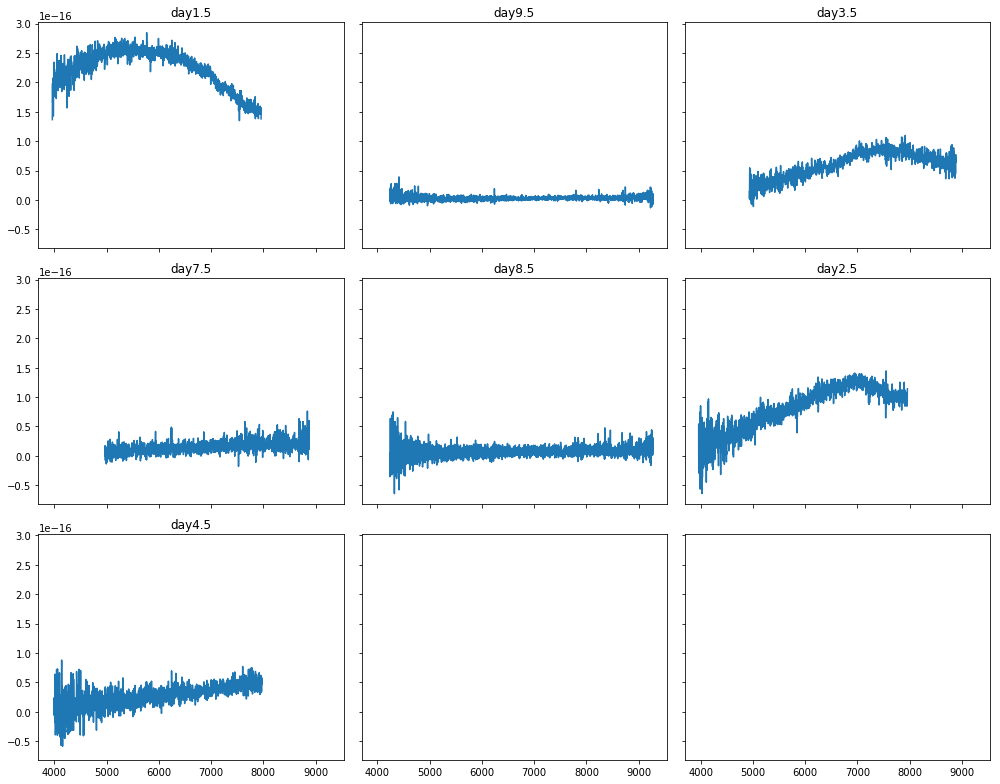

In [4]:
fig, axes = plt.subplots(3,3, figsize=(14,11), sharex=True, sharey=True)
axes = axes.flatten()

data = np.genfromtxt('{}/gw170817_day1.5_SOAR_restframe_dered.txt'.format(path))
ax = axes[0]
ax.plot(data[:,0], data[:,1], label='{}/gw170817_day1.5_SOAR_restframe_dered.txt')
axes[0].set_title('day1.5')

i = 1
for file in os.listdir(path):
    if file == 'gw170817_day1.5_SOAR_restframe_dered.txt':
        continue
    elif file.endswith('.txt'):
        tokens = file.split('_')
        res = np.genfromtxt('{}/{}'.format(path, file))
        ax = axes[i]
        ax.plot(res[:,0], res[:,1], label=file)
        axes[i].set_title(tokens[1])
        i = i + 1
    else:
        continue

fig.tight_layout()
fig.savefig('days.png')
        
print(data.shape)
print(data[0])

## Rebin and rescale fluxes

Rebins and rescales the fluxes from the original spectra.

In [5]:
flux = np.genfromtxt('{}/gw170817_day1.5_SOAR_restframe_dered.txt'.format(path))
rewave, reflux, reivar = rebin_flux(flux[:,0], flux[:,1], np.ones(flux.shape[0]), minwave=2500., maxwave=9500., nbins=150, log=True, clip=True)
rsflux = rescale_flux(reflux)

for file in os.listdir(path):
    if file == 'gw170817_day1.5_SOAR_restframe_dered.txt':
        continue
    elif file.endswith('.txt'):
        data = np.genfromtxt('{}/{}'.format(path, file))
        rewave, reflux, reivar = rebin_flux(data[:,0], data[:,1], np.ones(data.shape[0]), minwave=2500., maxwave=9500., nbins=150, log=True, clip=True)
        rsflux_new = rescale_flux(reflux)
        rsflux = np.vstack((rsflux, rsflux_new))
    else:
        continue

## Reshape and predict

Reshapes the fluxes above and uses the loaded model to classify each time step.

In [6]:
x_all = np.concatenate([rsflux
                       ]).reshape(-1, 150, 1)

print(rewave.shape)
print(reflux.shape)
print(rsflux.shape)

y_pred = model.predict(x_all)
np.set_printoptions(suppress=True)
print(y_pred)

(150,)
(150,)
(7, 150)
[[0.17391627 0.02571507 0.05025198 0.75011677]
 [0.02409446 0.00792725 0.00909408 0.95888424]
 [0.00147504 0.00074119 0.00057527 0.99720854]
 [0.00137636 0.00065217 0.00046432 0.99750715]
 [0.03155814 0.01815847 0.0136443  0.9366391 ]
 [0.00289712 0.00073295 0.00740731 0.9889626 ]
 [0.257893   0.06924926 0.04242603 0.6304318 ]]


## Label timesteps

This is the same prediction as y_pred, but it correctly labels each time step individually.

In [7]:
print('day1.5:')
flux_1 = np.genfromtxt('{}/gw170817_day1.5_SOAR_restframe_dered.txt'.format(path))
rewave_1, reflux_1, reivar_1 = rebin_flux(flux_1[:,0], flux_1[:,1], np.ones(flux_1.shape[0]), minwave=2500., maxwave=9500., nbins=150, log=True, clip=True)
rsflux_1 = rescale_flux(reflux_1)

x_1 = np.concatenate([rsflux_1
                     ]).reshape(-1, 150, 1)

y_pred_1 = model.predict(x_1)
print(y_pred_1)

print('day2.5:')
flux_2 = np.genfromtxt('{}/gw170817_day2.5_SOAR_restframe_dered.txt'.format(path))
rewave_2, reflux_2, reivar_2 = rebin_flux(flux_2[:,0], flux_2[:,1], np.ones(flux_2.shape[0]), minwave=2500., maxwave=9500., nbins=150, log=True, clip=True)
rsflux_2 = rescale_flux(reflux_2)

x_2 = np.concatenate([rsflux_2
                     ]).reshape(-1, 150, 1)

y_pred_2 = model.predict(x_2)
print(y_pred_2)

print('day3.5:')
flux_3 = np.genfromtxt('{}/gw170817_day3.5_SOAR_restframe_dered.txt'.format(path))
rewave_3, reflux_3, reivar_3 = rebin_flux(flux_3[:,0], flux_3[:,1], np.ones(flux_3.shape[0]), minwave=2500., maxwave=9500., nbins=150, log=True, clip=True)
rsflux_3 = rescale_flux(reflux_3)

x_3 = np.concatenate([rsflux_3
                     ]).reshape(-1, 150, 1)

y_pred_3 = model.predict(x_3)
print(y_pred_3)

print('day4.5:')
flux_4 = np.genfromtxt('{}/gw170817_day4.5_SOAR_restframe_dered.txt'.format(path))
rewave_4, reflux_4, reivar_4 = rebin_flux(flux_4[:,0], flux_4[:,1], np.ones(flux_4.shape[0]), minwave=2500., maxwave=9500., nbins=150, log=True, clip=True)
rsflux_4 = rescale_flux(reflux_4)

x_4 = np.concatenate([rsflux_4
                     ]).reshape(-1, 150, 1)

y_pred_4 = model.predict(x_4)
print(y_pred_4)

print('day7.5:')
flux_7 = np.genfromtxt('{}/gw170817_day7.5_SOAR_restframe_dered.txt'.format(path))
rewave_7, reflux_7, reivar_7 = rebin_flux(flux_7[:,0], flux_7[:,1], np.ones(flux_7.shape[0]), minwave=2500., maxwave=9500., nbins=150, log=True, clip=True)
rsflux_7 = rescale_flux(reflux_7)

x_7 = np.concatenate([rsflux_7
                     ]).reshape(-1, 150, 1)

y_pred_7 = model.predict(x_7)
print(y_pred_7)

print('day8.5:')
flux_8 = np.genfromtxt('{}/gw170817_day8.5_IMACS_restframe_dered.txt'.format(path))
rewave_8, reflux_8, reivar_8 = rebin_flux(flux_8[:,0], flux_8[:,1], np.ones(flux_8.shape[0]), minwave=2500., maxwave=9500., nbins=150, log=True, clip=True)
rsflux_8 = rescale_flux(reflux_8)

x_8 = np.concatenate([rsflux_8
                     ]).reshape(-1, 150, 1)

y_pred_8 = model.predict(x_8)
print(y_pred_8)

print('day9.5:')
flux_9 = np.genfromtxt('{}/gw170817_day9.5_IMACS_restframe_dered.txt'.format(path))
rewave_9, reflux_9, reivar_9 = rebin_flux(flux_9[:,0], flux_9[:,1], np.ones(flux_9.shape[0]), minwave=2500., maxwave=9500., nbins=150, log=True, clip=True)
rsflux_9 = rescale_flux(reflux_9)

x_9 = np.concatenate([rsflux_9
                     ]).reshape(-1, 150, 1)

y_pred_9 = model.predict(x_9)
print(y_pred_9)

day1.5:
[[0.17391627 0.02571507 0.05025199 0.75011677]]
day2.5:
[[0.00289712 0.00073295 0.00740732 0.9889626 ]]
day3.5:
[[0.00147504 0.00074119 0.00057527 0.99720854]]
day4.5:
[[0.257893   0.06924927 0.04242603 0.6304318 ]]
day7.5:
[[0.00137636 0.00065217 0.00046432 0.99750715]]
day8.5:
[[0.03155816 0.01815848 0.01364431 0.9366391 ]]
day9.5:
[[0.02409447 0.00792725 0.00909408 0.95888424]]


## DESI Spectra

Saves paths to models that have gone through desisim and condition those spectra.

In [8]:
path_to_150s = '/global/cscratch1/sd/lehsani/GW170817_150s'
truth_150s = sorted(glob('{}/*/*truth.fits'.format(path_to_150s)))
files_150s = sorted(glob('{}/*/*coadd.fits'.format(path_to_150s)))
flux_150s = condition_spectra(files_150s, truth_150s)

In [9]:
path_to_180s = '/global/cscratch1/sd/lehsani/GW170817_180s'
truth_180s = sorted(glob('{}/*/*truth.fits'.format(path_to_180s)))
files_180s = sorted(glob('{}/*/*coadd.fits'.format(path_to_180s)))
flux_180s = condition_spectra(files_180s, truth_180s)

In [10]:
path_to_200s = '/global/cscratch1/sd/lehsani/GW170817_200s'
truth_200s = sorted(glob('{}/*/*truth.fits'.format(path_to_200s)))
files_200s = sorted(glob('{}/*/*coadd.fits'.format(path_to_200s)))
flux_200s = condition_spectra(files_200s, truth_200s)

In [11]:
path_to_300s = '/global/cscratch1/sd/lehsani/GW170817_300s'
truth_300s = sorted(glob('{}/*/*truth.fits'.format(path_to_300s)))
files_300s = sorted(glob('{}/*/*coadd.fits'.format(path_to_300s)))
flux_300s = condition_spectra(files_300s, truth_300s)

In [13]:
n150s, nbins = flux_150s.shape
n180s, nbins = flux_180s.shape
n200s, nbins = flux_200s.shape
n300s, nbins = flux_300s.shape
n150s, n180s, n200s, n300s, nbins

(2079, 2086, 2092, 2091, 150)

## Reshape and predict

Reshapes and predicts the spectra from each different exposure time.

In [14]:
x_150s = np.concatenate([flux_150s]).reshape(-1, 150, 1)
y_pred_150s = model.predict(x_150s)

x_180s = np.concatenate([flux_180s]).reshape(-1, 150, 1)
y_pred_180s = model.predict(x_180s)

x_200s = np.concatenate([flux_200s]).reshape(-1, 150, 1)
y_pred_200s = model.predict(x_200s)

x_300s = np.concatenate([flux_300s]).reshape(-1, 150, 1)
y_pred_300s = model.predict(x_300s)

In [15]:
"""Get the accuracy of a prediction.
   
   Parameters
   ----------
   array : numpy array
       The prediction array, given by model.predict(x).
   time : string
       The exposure time to be printed above the accuracy breakdown.
    """

def get_acc(arr, time):
    len = arr.shape[0]

    threes = np.count_nonzero(arr == 3)
    twos = np.count_nonzero(arr == 2)
    ones = np.count_nonzero(arr == 1)
    zeroes = len - ones - twos - threes
    
    
    print('EXP ' + time)
    print('0s (galaxy): ', zeroes)
    print('1s (snia):   ', ones)
    print('2s (sniip):  ', twos)
    print('3s (kn):     ', threes)

    acc = threes / len
    print('accuracy: ', acc)
    print()
    
    return acc

## Get accuracies

Calculates and prints the amount of times the classifier chose each category and the overall KNe accuracy.

In [16]:
arr_150s = np.argmax(y_pred_150s, axis=1)
acc_150s = get_acc(arr_150s, '150s')

arr_180s = np.argmax(y_pred_180s, axis=1)
acc_180s = get_acc(arr_180s, '180s')

arr_200s = np.argmax(y_pred_200s, axis=1)
acc_200s = get_acc(arr_200s, '200s')

arr_300s = np.argmax(y_pred_300s, axis=1)
acc_300s = get_acc(arr_300s, '300s')

EXP 150s
0s (galaxy):  1678
1s (snia):    109
2s (sniip):   137
3s (kn):      155
accuracy:  0.07455507455507455

EXP 180s
0s (galaxy):  1621
1s (snia):    65
2s (sniip):   96
3s (kn):      304
accuracy:  0.1457334611697028

EXP 200s
0s (galaxy):  1771
1s (snia):    79
2s (sniip):   98
3s (kn):      144
accuracy:  0.06883365200764818

EXP 300s
0s (galaxy):  112
1s (snia):    24
2s (sniip):   52
3s (kn):      1903
accuracy:  0.9100908656145384



## Plot accuracy

Plots accuracy as a function of exposure time.

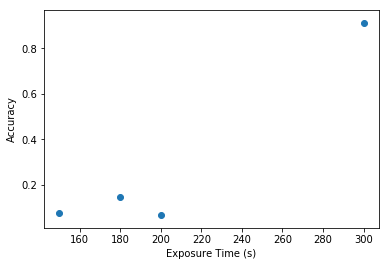

In [17]:
plt.scatter([150, 180, 200, 300], [acc_150s, acc_180s, acc_200s, acc_300s])
plt.xlabel('Exposure Time (s)')
plt.ylabel('Accuracy')
plt.savefig('acc_plot.png')